In [1]:
import  numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
from sklearn import linear_model, datasets
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [3]:
df_tr = pd.read_csv('train.csv')
df_tt = pd.read_csv('test.csv')

In [4]:
df_tr.count()

AnimalID          26729
Name              19038
DateTime          26729
OutcomeType       26729
OutcomeSubtype    13117
AnimalType        26729
SexuponOutcome    26728
AgeuponOutcome    26711
Breed             26729
Color             26729
dtype: int64

In [210]:
df_tt.Name.unique()

array(['Summer', 'Cheyenne', 'Gus', ..., 'Doogie', 'Caicos', 'Gusto'], dtype=object)

In [9]:
sex_dict   =   df_tr.loc[(df_tr.AnimalType == 'Cat' )&(df_tr.SexuponOutcome.notnull() > 0)  ].SexuponOutcome.unique()
bread_dict = df_tr.loc[(df_tr.AnimalType == 'Cat' )&(df_tr.Breed.notnull() > 0)  ].Breed.unique()
color_dict = df_tr.loc[(df_tr.AnimalType == 'Cat')  &(df_tr.Color.notnull() > 0)].Color.unique()

In [6]:
age_dict = df_tr.loc[(df_tr.AnimalType == 'Cat') &(df_tr.AgeuponOutcome.notnull() > 0) ].AgeuponOutcome.unique()

In [7]:
out_dict = df_tr.loc[(df_tr.AnimalType == 'Cat') &(df_tr.OutcomeType.notnull() > 0) ].OutcomeType.unique()


# Try to predict outcome using  SVM

In [8]:
def str_to_ind(row, in_str ,in_dict):
    if np.where(in_dict == row[in_str])[0].size > 0:
        return np.where(in_dict == row[in_str])[0][0]
    else:
        return -1

def age_to_float(row,in_str, in_dict):
    if np.where(in_dict == row[in_str])[0].size > 0:
        tmp_list = row[in_str].split()
        if tmp_list[1] == 'year' or tmp_list[1] == 'years' :
            return float(tmp_list[0])*1.0
        elif tmp_list[1] == 'month' or  tmp_list[1] == 'months':
            return float(tmp_list[0])*1.0/12.0
        else:
            return float(tmp_list[0])*1.0/52.1249
    else:
        return -1.0
            

In [10]:
df_tr['ind_outcome'] = df_tr.apply(lambda row: str_to_ind(row,'OutcomeType',out_dict), axis=1)
#df_tt['ind_outcome'] = df_tt.apply(lambda row: str_to_ind(row,'OutcomeType',out_dict), axis=1)

In [11]:
df_tr['ind_age'] = df_tr.apply(lambda row: age_to_float(row,'AgeuponOutcome',age_dict), axis=1)

In [12]:
df_tr['ind_breed'] = df_tr.apply(lambda row: str_to_ind(row,'Breed',bread_dict), axis=1)

In [13]:
df_tr['ind_color'] = df_tr.apply(lambda row: str_to_ind(row,'Color',color_dict), axis=1)
df_tr['ind_sex'] = df_tr.apply(lambda row: str_to_ind(row,'SexuponOutcome',sex_dict), axis=1)

In [14]:
df_tr['OutcomeType'].unique()

array(['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died'], dtype=object)

['Spayed Female' 'Intact Male' 'Unknown' 'Neutered Male' 'Intact Female']


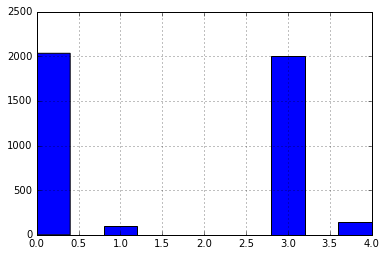

In [15]:
%matplotlib inline
print sex_dict
df_tr['ind_sex'].loc[(df_tr.AnimalType == 'Cat') &(df_tr['ind_outcome'] ==  2)].hist()

In [16]:
clean_df_tr = df_tr.loc[(df_tr.AnimalType == 'Cat') &  (df_tr.ind_sex >= 0 )& (df_tr.ind_breed >= 0 ) & (df_tr.ind_age >= 0 ) & (df_tr.ind_color >= 0 ) ][['ind_sex','ind_breed', 'ind_age','ind_color','ind_outcome']]

In [17]:
clean_df_tr['ind_outcome'] = clean_df_tr['ind_outcome'].apply(lambda x : 1 if x ==2 else 0)

In [18]:
np.random.seed(0)
msk = np.random.rand(len(clean_df_tr)) < 0.8
sub_tr = clean_df_tr[msk]
sub_tt = clean_df_tr[~msk]
sub_tr.count()

ind_sex        8935
ind_breed      8935
ind_age        8935
ind_color      8935
ind_outcome    8935
dtype: int64

In [ ]:
clf = svm.SVC(C=2,tol=1e-5,kernel='rbf')
clf.fit(sub_tr[['ind_sex', 'ind_age','ind_breed','ind_color']], sub_tr['ind_outcome'])

In [288]:
prd_y = clf.predict(sub_tt[['ind_sex', 'ind_age','ind_breed','ind_color']])

In [289]:
(prd_y == sub_tt['ind_outcome']).mean()

0.805224564619615

# Below we try to use adaboost, an ensemble method, to predict whether the cat will be adopted.

In [278]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), algorithm="SAMME.R",n_estimators=200)

In [279]:
bdt.fit(sub_tr[['ind_sex', 'ind_age','ind_breed','ind_color']], sub_tr['ind_outcome'])

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=200, random_state=None)

In [280]:
prd_y = bdt.predict(sub_tt[['ind_sex', 'ind_age','ind_breed','ind_color']])

In [281]:
(prd_y == sub_tt['ind_outcome']).mean()

0.8221814848762603